# 영화 흥행 예측 및 분류 프로젝트

## 프로젝트 개요

본 프로젝트는 영화 데이터를 활용하여 다음 두 가지 문제를 해결합니다:

**문제 1)** Decision Tree를 이용한 영화 흥행 예측  
- 제작비, 장르, 감독, 배우, 개봉 시기 등의 특징을 활용
- 흥행에 가장 중요한 요인(feature) 파악
- 영화 제작 초기 단계에서 흥행 여부 예측 가능성 검증

**문제 2)** K-means++ 클러스터링을 통한 영화 분류  
- 수익, 평점, 인기도, 제작비를 기준으로 군집화
- 각 군집의 특징 분석
- 실제 영화 추천 시스템에 활용 가능한지 검토

## 1. 환경 설정 및 라이브러리 임포트

In [3]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)
from sklearn.decomposition import PCA

# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# 랜덤 시드 고정
np.random.seed(42)

## 2. 데이터 로딩 및 탐색적 데이터 분석 (EDA)

### 2.1 데이터 로딩

In [4]:
# 데이터 로딩
df = pd.read_csv('data/movies.csv')

print(f"데이터셋 크기: {df.shape[0]:,}개 영화, {df.shape[1]}개 컬럼")
print(f"\n데이터 메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

데이터셋 크기: 4,803개 영화, 24개 컬럼

데이터 메모리 사용량: 26.33 MB


In [5]:
# 기본 정보 확인
df.head(10)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton
5,5,258000000,Fantasy Action Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity amnesia sandstorm love of one's ...,en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,Tobey Maguire Kirsten Dunst James Franco Thoma...,"[{'name': 'Francine Maisler', 'gender': 1, 'de...",Sam Raimi
6,6,260000000,Animation Family,http://disney.go.com/disneypictures/tangled/,38757,hostage magic horse fairy tale musical,en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,...,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330,Zachary Levi Mandy Moore Donna Murphy Ron Perl...,"[{'name': 'John Lasseter', 'gender': 2, 'depar...",Byron Howard
7,7,280000000,Action Adventure Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic sequel superhero based on comic b...,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,...,141.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,Robert Downey Jr. Chris Hemsworth Mark Ruffalo...,"[{'name': 'Danny Elfman', 'gender': 2, 'depart...",Joss Whedon
8,8,250000000,Adventure Fantasy Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch magic broom

In [6]:
# 데이터 타입 및 결측치 확인
info_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null %': (df.isnull().sum() / len(df) * 100).round(2)
})

print("\n=== 컬럼별 정보 ===")
print(info_df)


=== 컬럼별 정보 ===
                     Data Type  Non-Null Count  Null Count  Null %
index                    int64            4803           0    0.00
budget                   int64            4803           0    0.00
genres                  object            4775          28    0.58
homepage                object            1712        3091   64.36
id                       int64            4803           0    0.00
keywords                object            4391         412    8.58
original_language       object            4803           0    0.00
original_title          object            4803           0    0.00
overview                object            4800           3    0.06
popularity             float64            4803           0    0.00
production_companies    object            4803           0    0.00
production_countries    object            4803           0    0.00
release_date            object            4802           1    0.02
revenue                  int64            4803

### 2.2 수치형 변수 통계 요약

In [7]:
# 수치형 컬럼 통계
numeric_cols = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'runtime']
df[numeric_cols].describe()

,budget,revenue,popularity,vote_average,vote_count,runtime
count,4.803000e+03,4.803000e+03,4803.000000,4803.000000,4803.000000,4801.000000
mean,2.904504e+07,8.226064e+07,21.492301,6.092172,690.217989,106.875859
std,4.072239e+07,1.628571e+08,31.816650,1.194612,1234.585891,22.611935
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.900000e+05,0.000000e+00,4.668070,5.600000,54.000000,94.000000
50%,1.500000e+07,1.917000e+07,12.921594,6.200000,235.000000,103.000000
75%,4.000000e+07,9.291719e+07,28.313505,6.800000,737.000000,118.000000
max,3.800000e+08,2.787965e+09,875.581305,10.000000,13752.000000,338.000000


In [8]:
# 0값 분석 (실질적 결측치)
zero_analysis = pd.DataFrame({
    '0값 개수': (df[numeric_cols] == 0).sum(),
    '0값 비율(%)': ((df[numeric_cols] == 0).sum() / len(df) * 100).round(2)
})

print("\n=== 0값 분석 (실질적 결측치) ===")
print(zero_analysis)


=== 0값 분석 (실질적 결측치) ===
              0값 개수  0값 비율(%)
budget         1037     21.59
revenue        1427     29.71
popularity        1      0.02
vote_average     63      1.31
vote_count       62      1.29
runtime          35      0.73


### 2.3 시각화: 주요 변수 분포

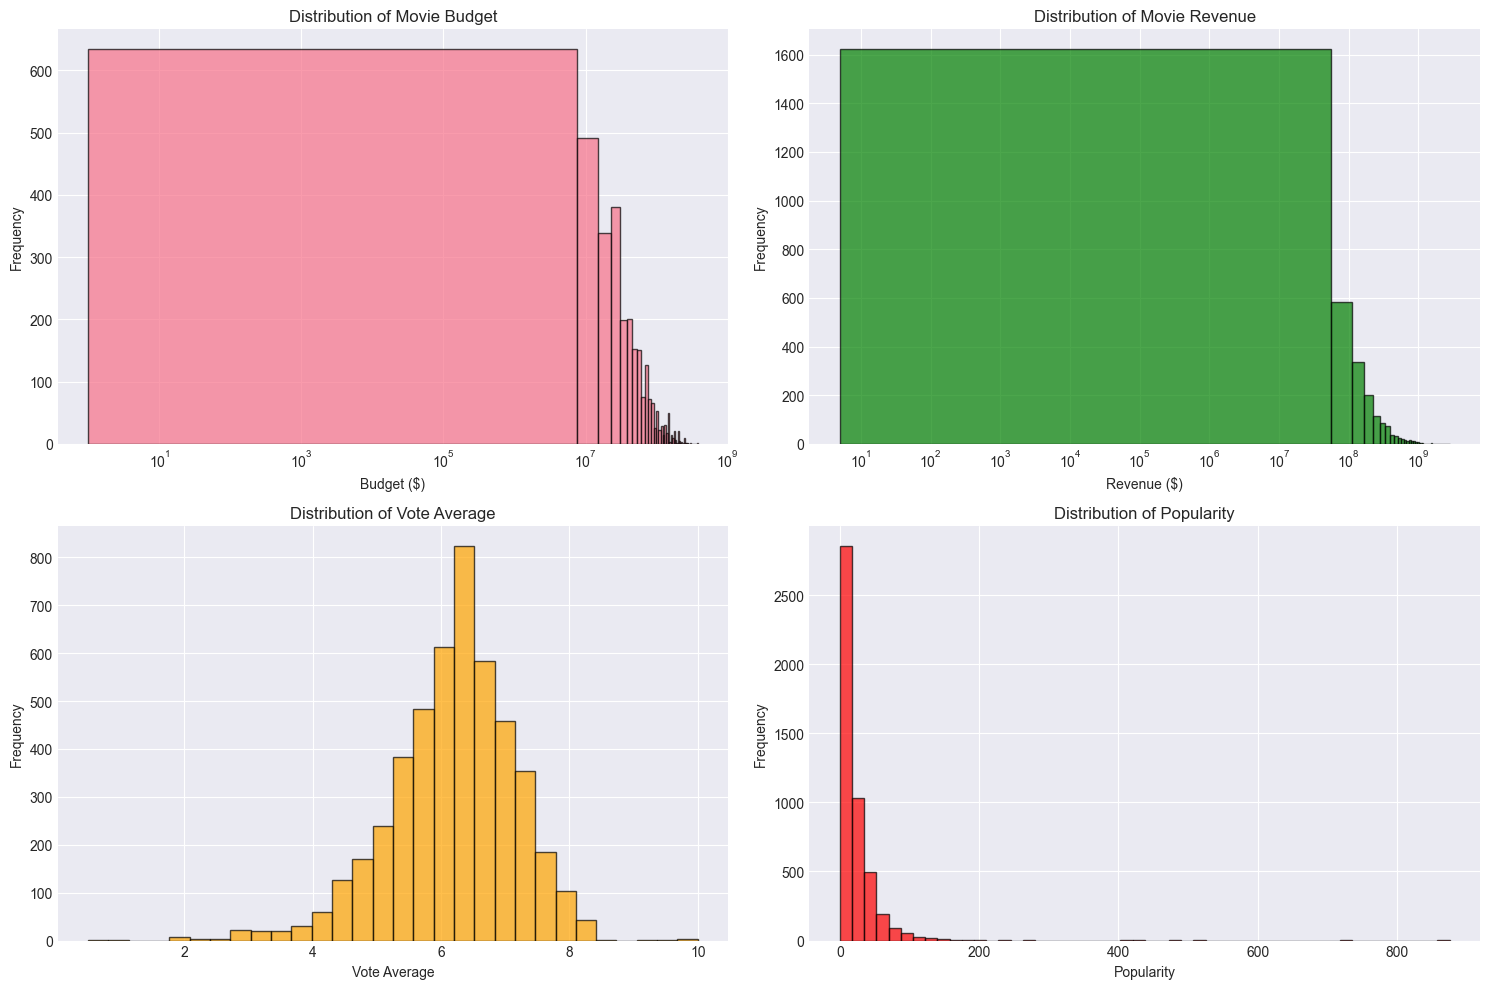

유효한 데이터 (budget > 0 AND revenue > 0): 3,229개 (67.23%)


In [9]:
# 제작비와 수익 분포 (로그 스케일)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 제작비 분포
df_valid = df[(df['budget'] > 0) & (df['revenue'] > 0)]
axes[0, 0].hist(df_valid['budget'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Budget ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Movie Budget')
axes[0, 0].set_xscale('log')

# 수익 분포
axes[0, 1].hist(df_valid['revenue'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Revenue ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Movie Revenue')
axes[0, 1].set_xscale('log')

# 평점 분포
axes[1, 0].hist(df[df['vote_average'] > 0]['vote_average'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Vote Average')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Vote Average')

# 인기도 분포
axes[1, 1].hist(df['popularity'], bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Popularity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Popularity')

plt.tight_layout()
plt.show()

print(f"유효한 데이터 (budget > 0 AND revenue > 0): {len(df_valid):,}개 ({len(df_valid)/len(df)*100:.2f}%)")

### 2.4 장르 분석


=== 장르 분포 (Top 15) ===
        Genre  Count  Percentage
0       Drama   2297       47.82
1      Comedy   1722       35.85
2    Thriller   1259       26.21
3      Action   1153       24.01
4     Romance    890       18.53
5   Adventure    790       16.45
6       Crime    696       14.49
7     Science    530       11.03
8     Fiction    530       11.03
9      Horror    519       10.81
10     Family    510       10.62
11    Fantasy    418        8.70
12    Mystery    347        7.22
13  Animation    234        4.87
14    History    197        4.10


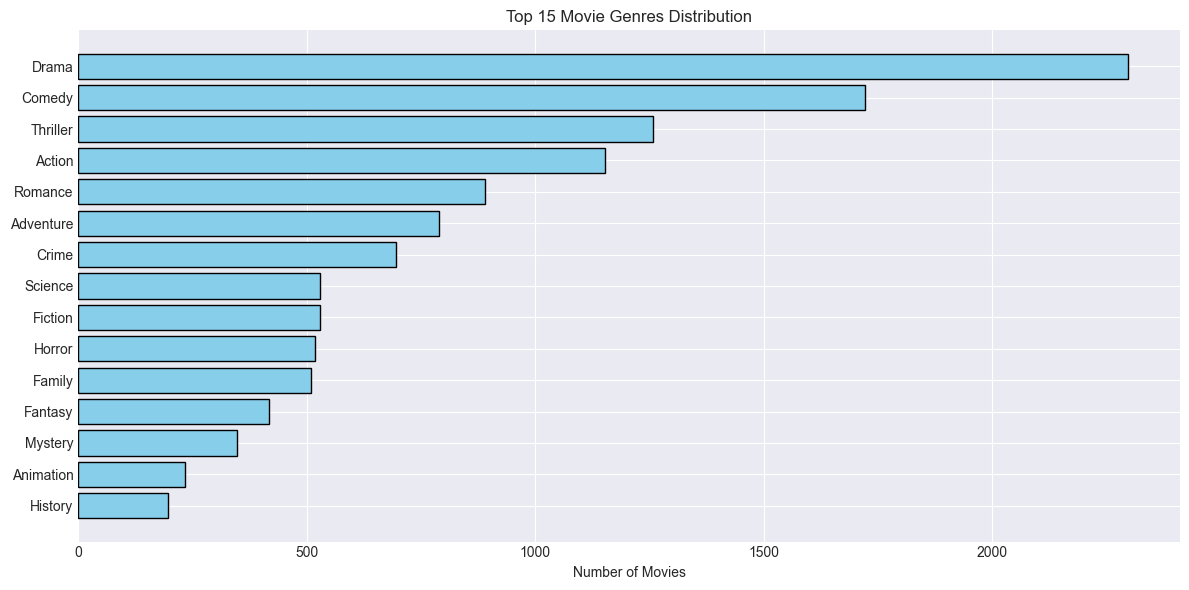

In [10]:
# 장르 분석
from collections import Counter

# 모든 장르 추출
all_genres = []
for genres in df['genres'].dropna():
    all_genres.extend(genres.split())

genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])
genre_df['Percentage'] = (genre_df['Count'] / len(df) * 100).round(2)

print("\n=== 장르 분포 (Top 15) ===")
print(genre_df)

# 장르 분포 시각화
plt.figure(figsize=(12, 6))
plt.barh(genre_df['Genre'], genre_df['Count'], color='skyblue', edgecolor='black')
plt.xlabel('Number of Movies')
plt.title('Top 15 Movie Genres Distribution')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2.5 개봉 시기 분석

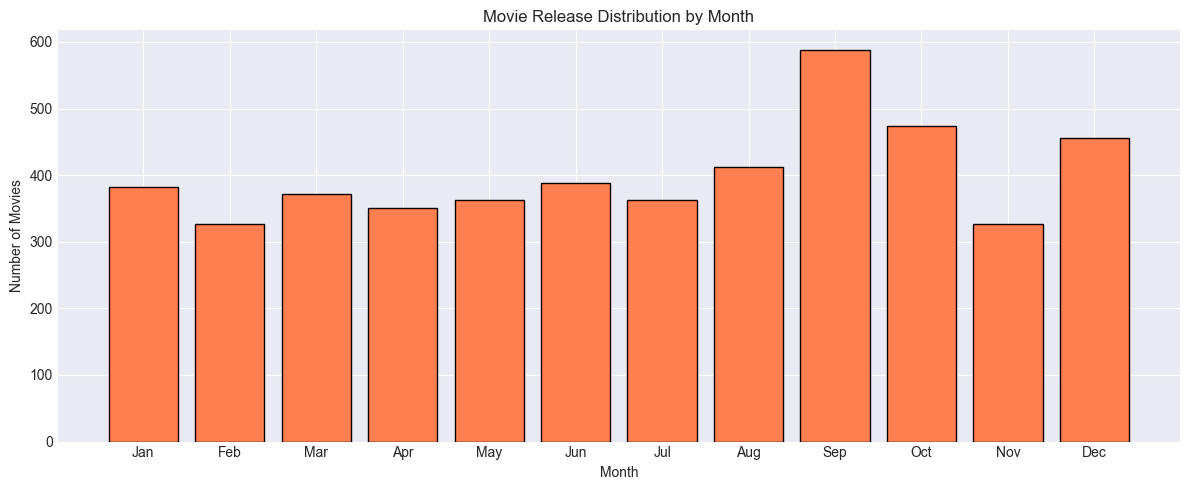


개봉 연도 범위: 1916 ~ 2017


In [11]:
# 개봉일 파싱
df['release_date_parsed'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date_parsed'].dt.year
df['release_month'] = df['release_date_parsed'].dt.month

# 월별 개봉 분포
month_counts = df['release_month'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(month_counts.index, month_counts.values, color='coral', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Distribution by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

print(f"\n개봉 연도 범위: {df['release_year'].min():.0f} ~ {df['release_year'].max():.0f}")

### 2.6 상관관계 분석

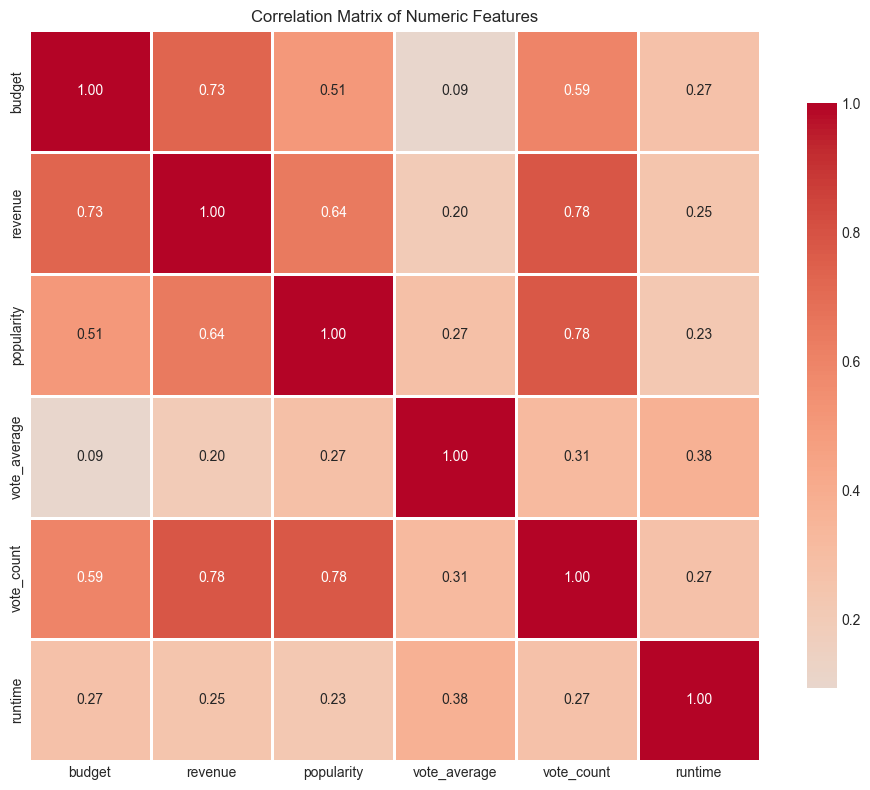

In [12]:
# 수치형 변수 간 상관관계
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## 3. 데이터 전처리 및 Feature Engineering

### 3.1 유효한 데이터만 필터링

In [13]:
# 작업용 데이터프레임 생성
df_clean = df.copy()

print(f"원본 데이터: {len(df_clean):,}개")

# 필수 컬럼의 0값 제거
df_clean = df_clean[
    (df_clean['budget'] > 0) & 
    (df_clean['revenue'] > 0) & 
    (df_clean['vote_average'] > 0) &
    (df_clean['runtime'] > 0)
]

print(f"필터링 후 (budget, revenue, vote_average, runtime > 0): {len(df_clean):,}개 ({len(df_clean)/len(df)*100:.2f}%)")

# 필수 컬럼의 결측치 제거
essential_cols = ['genres', 'release_date', 'director']
df_clean = df_clean.dropna(subset=essential_cols)

print(f"결측치 제거 후: {len(df_clean):,}개 ({len(df_clean)/len(df)*100:.2f}%)")

원본 데이터: 4,803개
필터링 후 (budget, revenue, vote_average, runtime > 0): 3,227개 (67.19%)
결측치 제거 후: 3,225개 (67.15%)


### 3.2 Feature Engineering

In [14]:
# 파생 변수 생성
# 1) 수익성 지표
df_clean['profit'] = df_clean['revenue'] - df_clean['budget']
df_clean['roi'] = ((df_clean['revenue'] - df_clean['budget']) / df_clean['budget'] * 100)
df_clean['is_profitable'] = (df_clean['revenue'] > df_clean['budget']).astype(int)

# 2) 시간 특징
df_clean['release_date_parsed'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
df_clean['release_year'] = df_clean['release_date_parsed'].dt.year
df_clean['release_month'] = df_clean['release_date_parsed'].dt.month
df_clean['release_season'] = ((df_clean['release_month'] - 1) // 3 + 1)  # 1=겨울, 2=봄, 3=여름, 4=가을
df_clean['is_summer_release'] = df_clean['release_month'].isin([6, 7, 8]).astype(int)
df_clean['is_holiday_release'] = df_clean['release_month'].isin([11, 12]).astype(int)

# 3) 제작비 카테고리
df_clean['budget_category'] = pd.cut(
    df_clean['budget'],
    bins=[0, 5e6, 2e7, 1e8, np.inf],
    labels=['Low', 'Medium', 'High', 'Blockbuster']
)

# 4) 장르 수
df_clean['num_genres'] = df_clean['genres'].str.split().str.len()

# 5) 캐스트 수
df_clean['num_cast'] = df_clean['cast'].fillna('').str.split().str.len()

# 6) 인기도-평점 조합
df_clean['popularity_rating'] = df_clean['popularity'] * df_clean['vote_average']
df_clean['weighted_rating'] = df_clean['vote_average'] * np.log1p(df_clean['vote_count'])

print("\n=== 파생 변수 생성 됨 ===")
print(f"추가된 컬럼 수: 13개")
print(f"총 컬럼 수: {df_clean.shape[1]}개")


=== 파생 변수 생성 됨 ===
추가된 컬럼 수: 13개
총 컬럼 수: 38개


### 3.3 장르 One-Hot Encoding

In [15]:
# 장르를 리스트로 변환
genres_list = df_clean['genres'].str.split().tolist()

# MultiLabelBinarizer 사용
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(genres_list)
genres_encoded_df = pd.DataFrame(genres_encoded, columns=[f'genre_{g}' for g in mlb.classes_], index=df_clean.index)

# 원본 데이터프레임에 병합
df_clean = pd.concat([df_clean, genres_encoded_df], axis=1)

print(f"\n장르 One-Hot Encoding 됨: {len(mlb.classes_)}개 장르")
print(f"장르 목록: {', '.join(mlb.classes_)}")


장르 One-Hot Encoding 됨: 20개 장르
장르 목록: Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, Fiction, Foreign, History, Horror, Music, Mystery, Romance, Science, Thriller, War, Western


### 3.4 타겟 변수 생성 (V1: 실질적 수익 기준)

**V1 타겟 정의**: revenue >= 2 × budget

**선택 이유**:
1. 영화 산업 표준: 제작비의 2배 이상 수익을 "실질적 성공"으로 간주
2. 마케팅 비용 고려: 제작비 외 마케팅, 배급 비용 포
3. 함 시 약 2배 필요
3. Data Leakage 없음: 제작 단계에서 예측 가능한 정보만 사용
4. 예측 가능성: vote_average 같은 개봉 후 정보 미사용
5. 비즈니스 목표 부합: 투자자 관점의 실질적 수익성 평가


=== 흥행 여부 분포 ===
흥행 (1): 1,809개 (56.09%)
비흥행 (0): 1,416개 (43.91%)


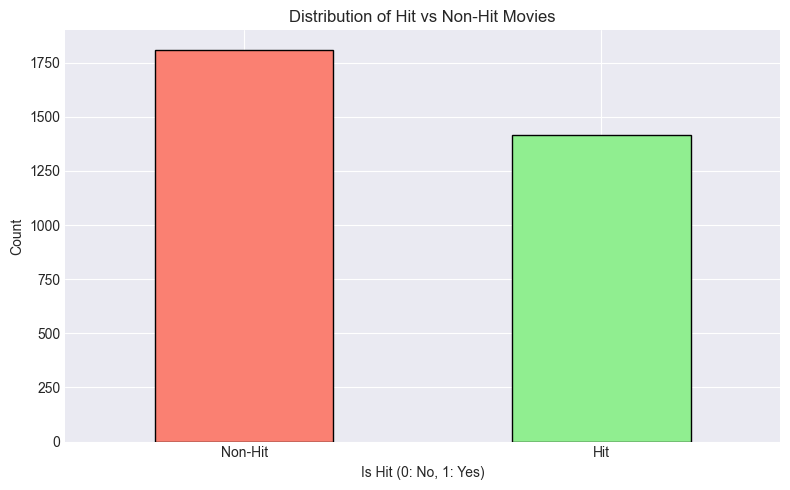

In [16]:
# 타겟 변수 생성
df_clean['hit'] = (df_clean['revenue'] >= 2 * df_clean['budget']).astype(int)

# release_date를 release_year(연), release_month(월) 꼴로 분해
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
df_clean['release_year'] = df_clean['release_date'].dt.year
df_clean['release_month'] = df_clean['release_date'].dt.month

hit_distribution = df_clean['hit'].value_counts()
print("\n=== 흥행 여부 분포 ===")
print(f"흥행 (1): {hit_distribution[1]:,}개 ({hit_distribution[1]/len(df_clean)*100:.2f}%)")
print(f"비흥행 (0): {hit_distribution[0]:,}개 ({hit_distribution[0]/len(df_clean)*100:.2f}%)")

# 시각화
plt.figure(figsize=(8, 5))
hit_distribution.plot(kind='bar', color=['salmon', 'lightgreen'], edgecolor='black')
plt.xlabel('Is Hit (0: No, 1: Yes)')
plt.ylabel('Count')
plt.title('Distribution of Hit vs Non-Hit Movies')
plt.xticks([0, 1], ['Non-Hit', 'Hit'], rotation=0)
plt.tight_layout()
plt.show()

## 4. 문제 1: Decision Tree 기반 흥행 예측 (V1 타겟)

### 4.1 특징 선택 및 데이터 준비

In [17]:
# Decision Tree를 위한 특징 선택
feature_cols = [   'budget', 'popularity', 'vote_average', 'vote_count', 'runtime',    'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast',    'is_summer_release', 'is_holiday_release',    'popularity_rating', 'weighted_rating'] + [col for col in df_clean.columns if col.startswith('genre_')]

X = df_clean[feature_cols]
y = df_clean['hit']
print(f"\n특징 개수: {len(feature_cols)}개")
print(f"샘플 수: {len(X):,}개")
print(f"\n주요 특징 (처음 20개):")
print(feature_cols[:20])


특징 개수: 34개
샘플 수: 3,225개

주요 특징 (처음 20개):
['budget', 'popularity', 'vote_average', 'vote_count', 'runtime', 'release_month', 'release_season', 'release_year', 'num_genres', 'num_cast', 'is_summer_release', 'is_holiday_release', 'popularity_rating', 'weighted_rating', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary']


### 4.2 Train/Test 분할

In [18]:
# 80/20 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== 데이터 분할 ===")
print(f"Train set: {len(X_train):,}개")
print(f"Test set: {len(X_test):,}개")
print(f"\nTrain set - 흥행 비율: {y_train.mean()*100:.2f}%")
print(f"Test set - 흥행 비율: {y_test.mean()*100:.2f}%")


=== 데이터 분할 ===
Train set: 2,580개
Test set: 645개

Train set - 흥행 비율: 56.09%
Test set - 흥행 비율: 56.12%


### 4.3 Decision Tree 모델 학습

In [19]:
# Decision Tree 모델 (과적합 방지를 위해 max_depth 제한)
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# 학습
dt_model.fit(X_train, y_train)

print("\nDecision Tree 모델 학습 됨")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")


Decision Tree 모델 학습 됨
Tree depth: 10
Number of leaves: 142


### 4.4 모델 평가

In [20]:
# 예측
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# 성능 지표 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\n=== Decision Tree 성능 평가 ===")
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nTest Set Metrics:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

# 분류 리포트
print(f"\n{classification_report(y_test, y_test_pred, target_names=['Non-Hit', 'Hit'])}")


=== Decision Tree 성능 평가 ===

Train Accuracy: 0.8322
Test Accuracy: 0.7163

Test Set Metrics:
  Precision: 0.7452
  Recall: 0.7514
  F1-Score: 0.7483

              precision    recall  f1-score   support

     Non-Hit       0.68      0.67      0.67       283
         Hit       0.75      0.75      0.75       362

    accuracy                           0.72       645
   macro avg       0.71      0.71      0.71       645
weighted avg       0.72      0.72      0.72       645



### 4.5 Confusion Matrix

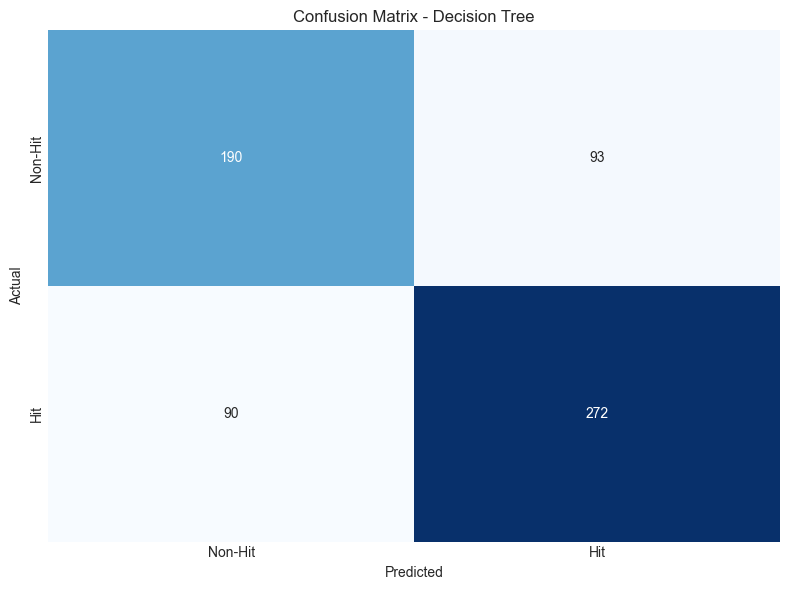


True Negatives: 190
False Positives: 93
False Negatives: 90
True Positives: 272


In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

### 4.6 ROC Curve 및 AUC

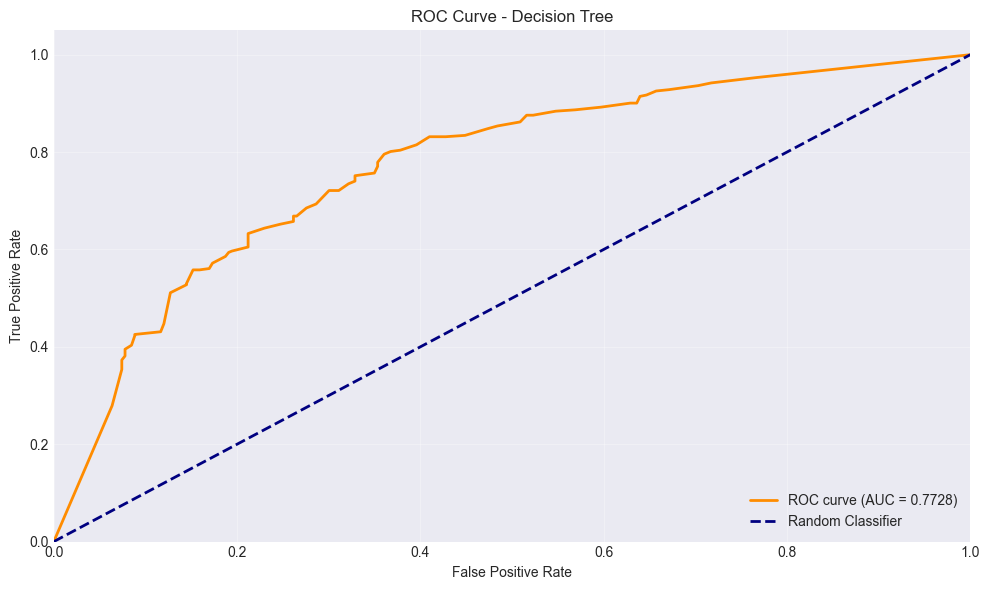


ROC-AUC Score: 0.7728


In [22]:
# ROC Curve
y_test_proba = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

### 4.7 Feature Importance 분석


=== Top 20 중요한 특징 ===
           feature  importance
   weighted_rating    0.298527
        vote_count    0.178295
            budget    0.161236
      release_year    0.143084
 popularity_rating    0.033555
           runtime    0.031142
        num_genres    0.028525
        popularity    0.022922
      vote_average    0.021623
     release_month    0.014019
      genre_Comedy    0.011207
       genre_Drama    0.010738
          num_cast    0.009103
    genre_Thriller    0.008929
      genre_Horror    0.008212
       genre_Crime    0.007032
   genre_Adventure    0.005369
     genre_Fiction    0.003383
 is_summer_release    0.003099
is_holiday_release    0.000000


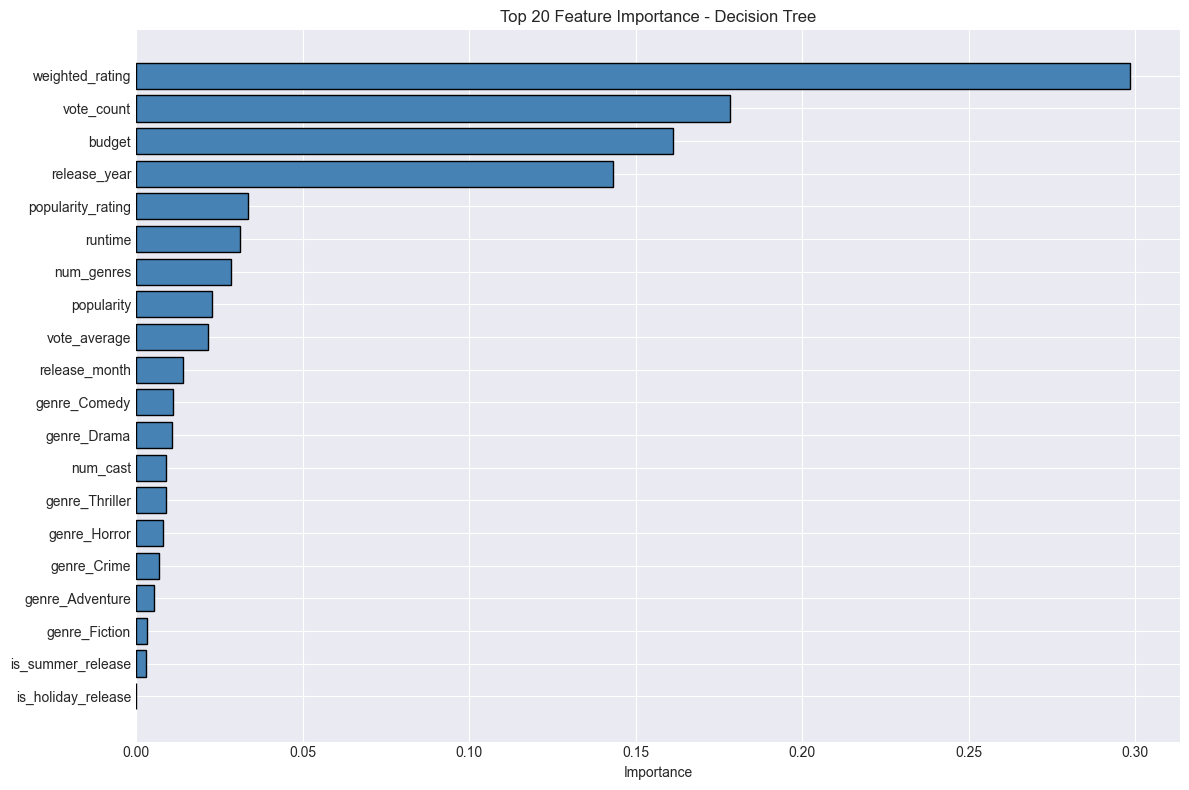

In [23]:
# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 중요 특징
top_20_features = feature_importance.head(20)

print("\n=== Top 20 중요한 특징 ===")
print(top_20_features.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 4.8 Decision Tree 시각화 (일부)

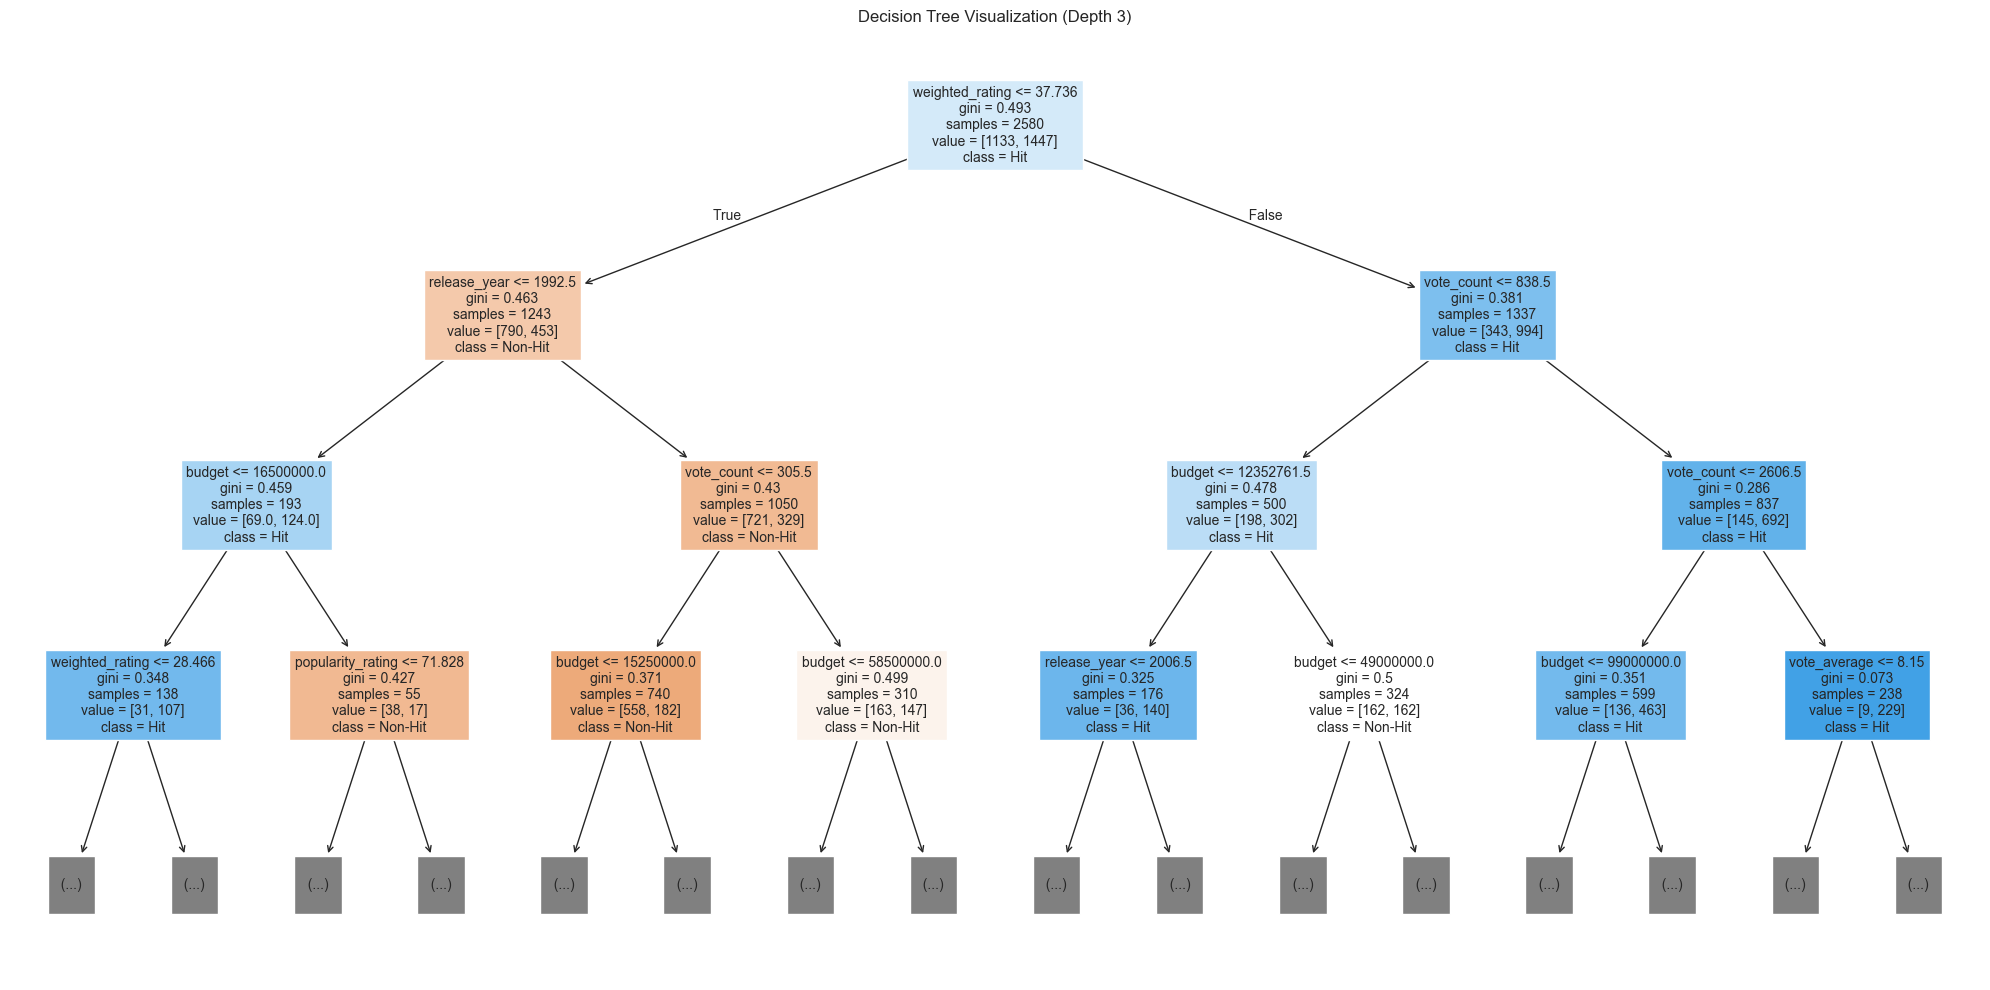

In [24]:
# 트리 일부 시각화 (max_depth=3까지만)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          max_depth=3,
          feature_names=feature_cols,
          class_names=['Non-Hit', 'Hit'],
          filled=True,
          fontsize=10)
plt.title('Decision Tree Visualization (Depth 3)')
plt.tight_layout()
plt.show()

## 5. 문제 2: K-means++ 클러스터링 (V1 타겟)

### 4.1 클러스터링을 위한 데이터 준비

In [25]:
clustering_features = ['budget', 'runtime', 'popularity', 'vote_average']
X_cluster = df_clean[clustering_features].copy()
print(f"\n=== K-means++ 클러스터링 데이터 ===")
print(f"샘플 수: {len(X_cluster):,}개")
print(f"특징: {clustering_features}")
print(f"\n기본 통계:")
print(X_cluster.describe())


=== K-means++ 클러스터링 데이터 ===
샘플 수: 3,225개
특징: ['budget', 'runtime', 'popularity', 'vote_average']

기본 통계:
             budget      runtime   popularity  vote_average
count  3.225000e+03  3225.000000  3225.000000    3225.00000
mean   4.070121e+07   110.723411    29.069419       6.31355
std    4.440431e+07    20.973909    36.173911       0.85985
min    1.000000e+00    41.000000     0.019984       2.30000
25%    1.050000e+07    96.000000    10.484642       5.80000
50%    2.500000e+07   107.000000    20.428237       6.30000
75%    5.500000e+07   121.000000    37.355826       6.90000
max    3.800000e+08   338.000000   875.581305       8.50000


### 4.2 데이터 스케일링

In [26]:
# StandardScaler 적용 (K-means는 스케일에 민감)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("\nStandardScaler 적용 됨")
print(f"스케일링 후 평균: {X_cluster_scaled.mean(axis=0)}")
print(f"스케일링 후 표준편차: {X_cluster_scaled.std(axis=0)}")


StandardScaler 적용 됨
스케일링 후 평균: [0.00000000e+00 2.82013861e-16 7.05034653e-17 1.53345037e-15]
스케일링 후 표준편차: [1. 1. 1. 1.]


### 4.3 최적 클러스터 수 결정 (Elbow Method)

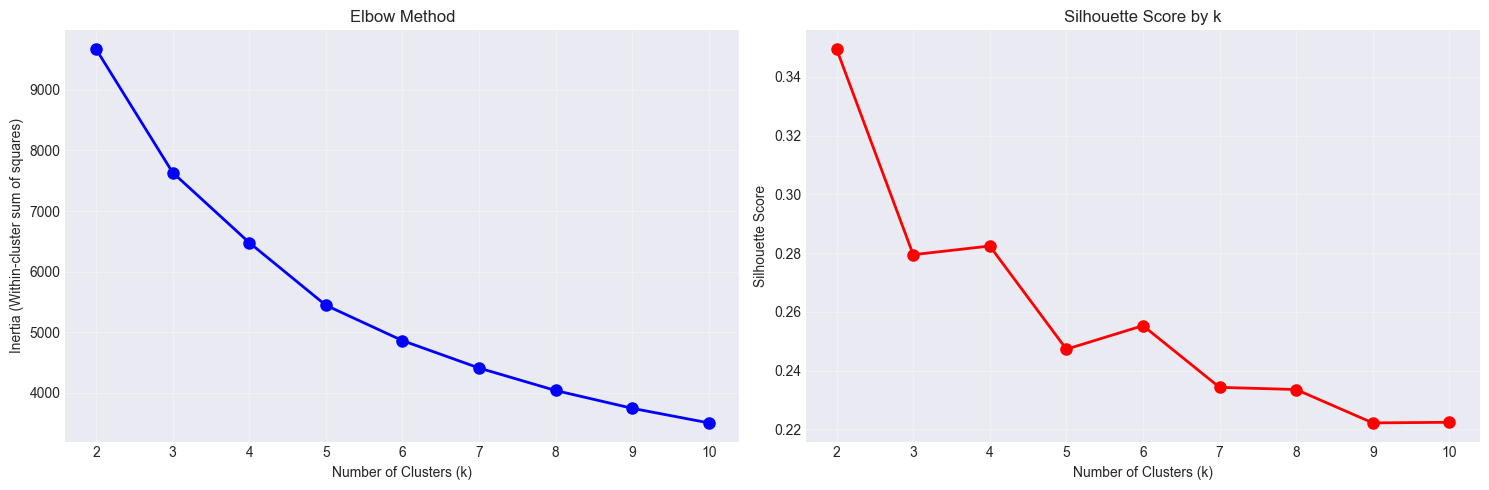


최적 클러스터 수 (Silhouette Score 기준): k = 2
최고 Silhouette Score: 0.3495


In [27]:
# Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method')
axes[0].grid(alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by k')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 최적 k 찾기
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n최적 클러스터 수 (Silhouette Score 기준): k = {best_k}")
print(f"최고 Silhouette Score: {max(silhouette_scores):.4f}")

### 4.4 K-means++ 클러스터링 수행

In [28]:
# 인덱스 리셋 및 클러스터링
df_clean = df_clean.reset_index(drop=True)
X_cluster = df_clean[clustering_features].copy()
X_cluster_scaled = scaler.transform(X_cluster)

kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)
df_clean['cluster'] = cluster_labels

print(f"\nK-means++ 클러스터링 (k={best_k})")
print(f"\n클러스터별 영화 수:")
print(df_clean['cluster'].value_counts().sort_index())


K-means++ 클러스터링 (k=2)

클러스터별 영화 수:
cluster
0    2355
1     870
Name: count, dtype: int64


### 4.5 클러스터 평가

In [29]:
# 평가 지표 계산
silhouette = silhouette_score(X_cluster_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_cluster_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_cluster_scaled, cluster_labels)

print("\n=== 클러스터링 평가 지표 ===")
print(f"Silhouette Score: {silhouette:.4f} (높을수록 좋음, -1~1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (낮을수록 좋음)")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f} (높을수록 좋음)")


=== 클러스터링 평가 지표 ===
Silhouette Score: 0.3495 (높을수록 좋음, -1~1)
Davies-Bouldin Index: 1.4429 (낮을수록 좋음)
Calinski-Harabasz Score: 1076.58 (높을수록 좋음)


### 4.6 클러스터별 특성 분석

In [30]:
# 클러스터별 평균값
cluster_analysis = df_clean.groupby('cluster')[clustering_features + ['roi', 'profit', 'hit']].mean()

print("\n=== 클러스터별 평균 특성 ===")
print(cluster_analysis.round(2))

# 클러스터별 영화 수
cluster_counts = df_clean['cluster'].value_counts().sort_index()
cluster_analysis['count'] = cluster_counts

print("\n=== 클러스터별 영화 수 ===")
print(cluster_counts)


=== 클러스터별 평균 특성 ===
              budget  runtime  popularity  vote_average        roi  \
cluster                                                              
0        27464062.68   102.95       19.21          6.09  404850.93   
1        76532798.35   131.75       55.77          6.93     420.24   

               profit   hit  
cluster                      
0        3.883916e+07  0.51  
1        1.939806e+08  0.70  

=== 클러스터별 영화 수 ===
cluster
0    2355
1     870
Name: count, dtype: int64


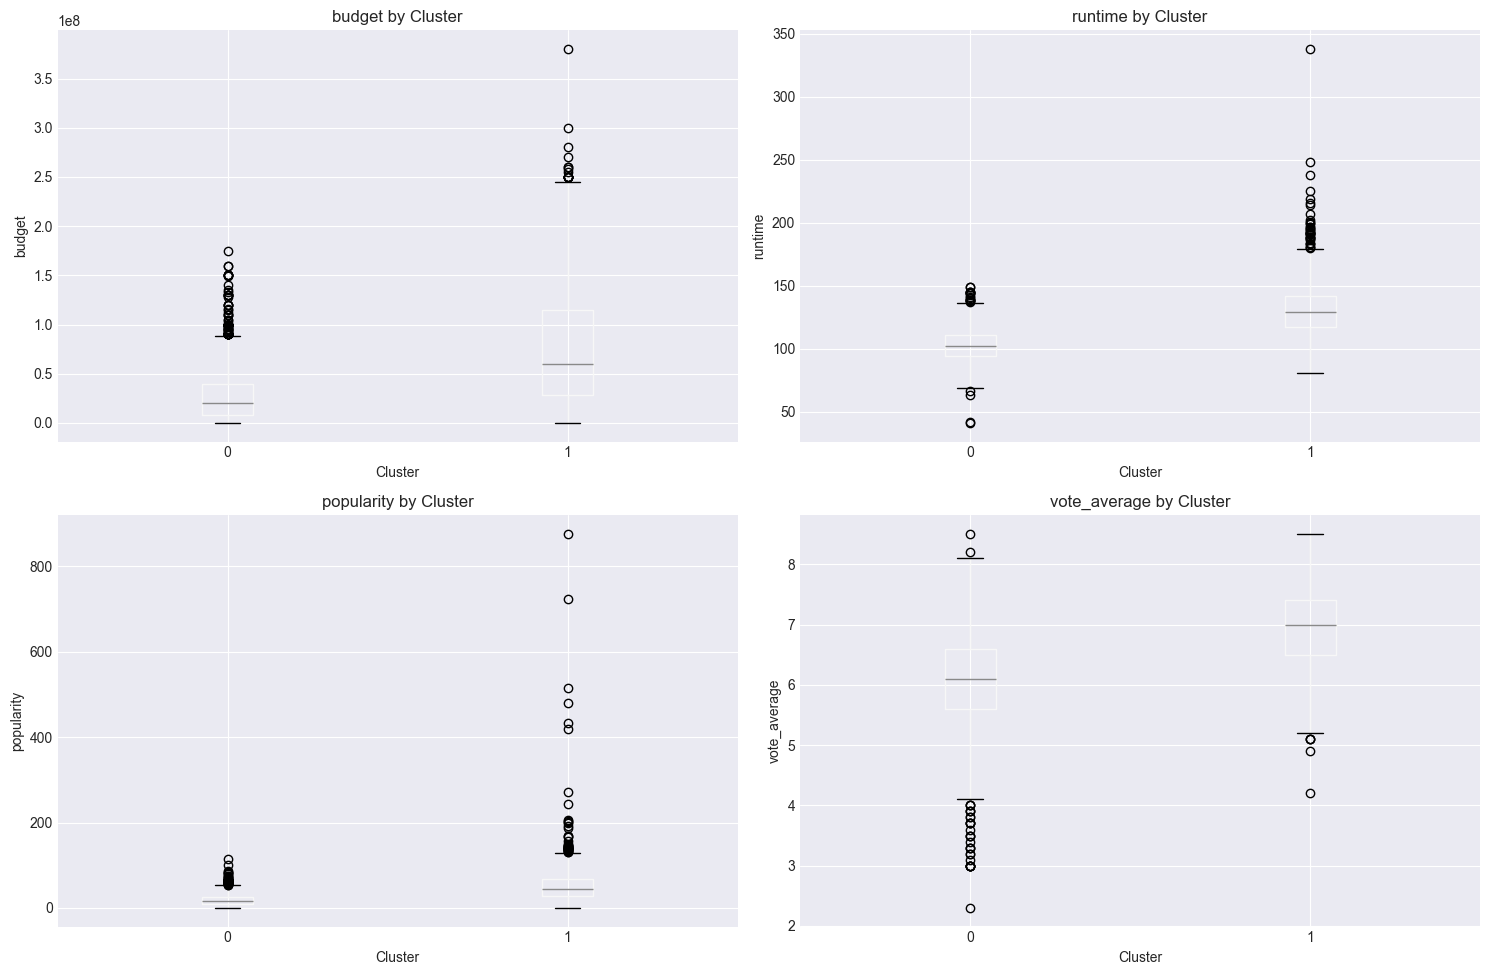

In [31]:
# 클러스터별 특성 시각화 (박스플롯)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, feature in enumerate(clustering_features):
    row = idx // 2
    col = idx % 2
    
    df_clean.boxplot(column=feature, by='cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

### 4.7 클러스터 시각화 (PCA 2D)

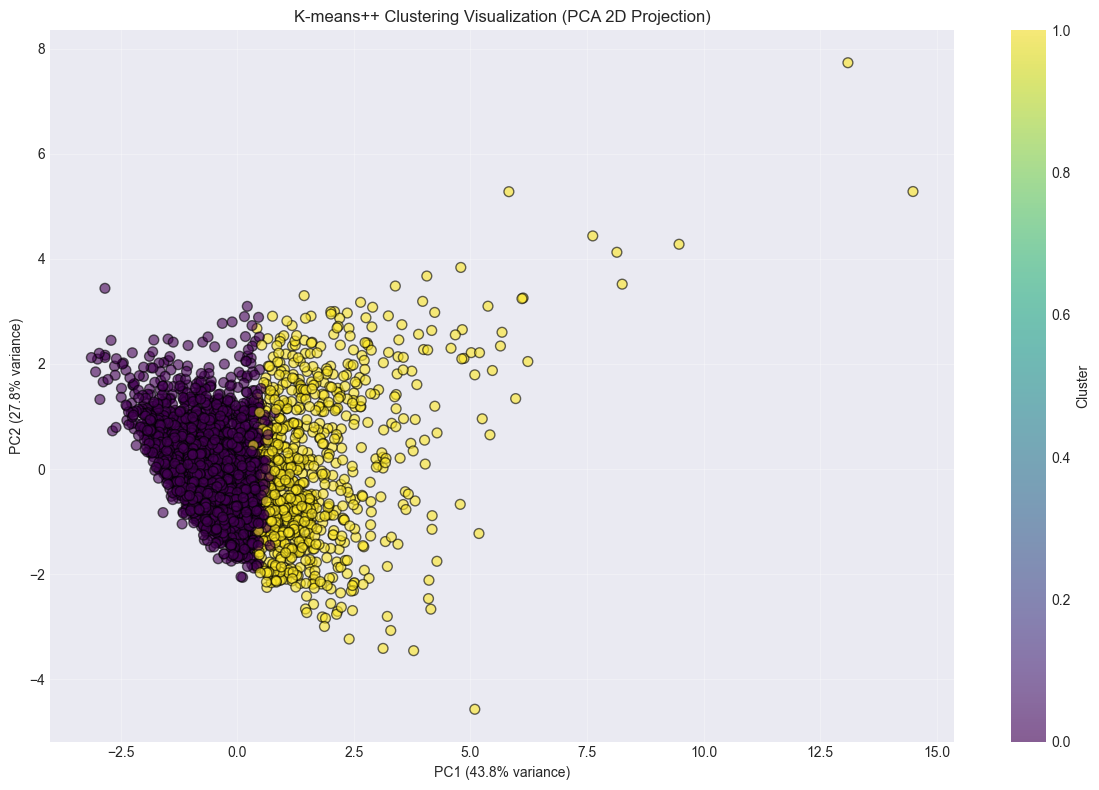


PCA 설명 분산 비율: PC1=43.78%, PC2=27.83%
총 설명 분산: 71.61%


In [32]:
# PCA로 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50, edgecolors='black')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('K-means++ Clustering Visualization (PCA 2D Projection)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPCA 설명 분산 비율: PC1={pca.explained_variance_ratio_[0]*100:.2f}%, PC2={pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"총 설명 분산: {sum(pca.explained_variance_ratio_)*100:.2f}%")

### 4.8 클러스터 해석 및 대표 영화

In [33]:
# 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화)
from scipy.spatial.distance import cdist

# 센트로이드와의 거리 계산
centroids = kmeans_final.cluster_centers_
distances = cdist(X_cluster_scaled, centroids, 'euclidean')

print("\n=== 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화 3개) ===")
for cluster_id in range(best_k):
    # 해당 클러스터의 영화들
    cluster_movies = df_clean[df_clean['cluster'] == cluster_id]
    cluster_indices = cluster_movies.index
    
    # 센트로이드와의 거리
    cluster_distances = distances[cluster_indices, cluster_id]
    
    # 가장 가까운 3개 영화
    closest_indices = cluster_indices[np.argsort(cluster_distances)[:3]]
    
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"영화 수: {len(cluster_movies)}개")
    print(f"평균 제작비: ${cluster_movies['budget'].mean():,.0f}")
    print(f"평균 수익: ${cluster_movies['revenue'].mean():,.0f}")
    print(f"평균 ROI: {cluster_movies['roi'].mean():.1f}%")
    print(f"평균 평점: {cluster_movies['vote_average'].mean():.2f}")
    print(f"흥행 비율: {cluster_movies['hit'].mean()*100:.1f}%")
    print(f"\n대표 영화:")
    for idx in closest_indices:
        movie = df_clean.loc[idx]
        print(f"  - {movie['title']} ({movie['release_year']:.0f})")
        print(f"    제작비: ${movie['budget']:,.0f}, 수익: ${movie['revenue']:,.0f}, 평점: {movie['vote_average']:.1f}")


=== 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화 3개) ===

--- Cluster 0 ---
영화 수: 2355개
평균 제작비: $27,464,063
평균 수익: $66,303,223
평균 ROI: 404850.9%
평균 평점: 6.09
흥행 비율: 51.0%

대표 영화:
  - No Reservations (2007)
    제작비: $28,000,000, 수익: $92,601,050, 평점: 6.1
  - Hide and Seek (2005)
    제작비: $25,000,000, 수익: $122,644,820, 평점: 6.1
  - War (2007)
    제작비: $25,000,000, 수익: $40,452,643, 평점: 6.0

--- Cluster 1 ---
영화 수: 870개
평균 제작비: $76,532,798
평균 수익: $270,513,370
평균 ROI: 420.2%
평균 평점: 6.93
흥행 비율: 69.8%

대표 영화:
  - The Rock (1996)
    제작비: $75,000,000, 수익: $335,062,621, 평점: 6.9
  - Sherlock Holmes (2009)
    제작비: $90,000,000, 수익: $524,028,679, 평점: 7.0
  - Die Hard: With a Vengeance (1995)
    제작비: $90,000,000, 수익: $366,101,666, 평점: 6.9


### 5.9 클러스터 명명 및 해석

In [39]:
# 클러스터 명명 함수 (3단계 규칙)
def name_cluster(df_clean, cluster_id):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    # 제작비 규모
    avg_budget = cluster_data['budget'].mean()
    if avg_budget < 20e6:
        budget_tier = "Low-Budget"
    elif avg_budget < 60e6:
        budget_tier = "Mid-Budget"
    else:
        budget_tier = "High-Budget"
    
    # 흥행 성공률
    hit_rate = cluster_data['hit'].mean()
    if hit_rate > 0.65:
        success_tier = "High Success"
    elif hit_rate > 0.5:
        success_tier = "Moderate Success"
    else:
        success_tier = "Low Success"
    
    # 주요 장르
    genre_cols = [col for col in df_clean.columns if col.startswith('genre_')]
    genre_dist = cluster_data[genre_cols].mean().sort_values(ascending=False)
    top_genre = genre_dist.index[0].replace('genre_', '')
    
    return f"{budget_tier} {success_tier} ({top_genre}-heavy)"


# 클러스터별 명명 및 분석
cluster_names = {}

print("\n=== 클러스터 명명 및 특성 분석 ===\n")

for cluster_id in range(best_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    cluster_names[cluster_id] = name_cluster(df_clean, cluster_id)
    
    print(f"Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"  영화 수: {len(cluster_data):,}개 ({len(cluster_data)/len(df_clean)*100:.1f}%)")
    print(f"  평균 제작비: ${cluster_data['budget'].mean():,.0f}")
    print(f"  평균 수익: ${cluster_data['revenue'].mean():,.0f}")
    print(f"  평균 평점: {cluster_data['vote_average'].mean():.2f}")
    print(f"  흥행 성공률: {cluster_data['hit'].mean()*100:.1f}%")
    
    # 장르 분포 Top 3
    genre_cols = [col for col in df_clean.columns if col.startswith('genre_')]
    genre_dist = cluster_data[genre_cols].mean().sort_values(ascending=False)
    genres_str = ", ".join([f"{g.replace('genre_', '')} ({v*100:.1f}%)" 
                            for g, v in genre_dist.head(3).items()])
    print(f"  주요 장르: {genres_str}")
    print()


=== 클러스터 명명 및 특성 분석 ===

Cluster 0: Mid-Budget Moderate Success (Drama-heavy)
  영화 수: 2,355개 (73.0%)
  평균 제작비: $27,464,063
  평균 수익: $66,303,223
  평균 평점: 6.09
  흥행 성공률: 51.0%
  주요 장르: Drama (41.5%), Comedy (41.2%), Thriller (29.1%)

Cluster 1: High-Budget High Success (Drama-heavy)
  영화 수: 870개 (27.0%)
  평균 제작비: $76,532,798
  평균 수익: $270,513,370
  평균 평점: 6.93
  흥행 성공률: 69.8%
  주요 장르: Drama (53.0%), Action (37.2%), Adventure (33.7%)



## 6. 비즈니스 인사이트 (V1 기준)

### 5.1 Decision Tree 주요 발견사항

In [36]:
print("\n=== Decision Tree 분석 결과 요약 ===")
print(f"\n1. 모델 성능")
print(f"   - Test Accuracy: {test_accuracy:.2%}")
print(f"   - Precision: {test_precision:.2%}")
print(f"   - Recall: {test_recall:.2%}")
print(f"   - F1-Score: {test_f1:.2%}")
print(f"   - ROC-AUC: {roc_auc:.4f}")

print(f"\n2. 흥행 예측에 가장 중요한 요인 (Top 5)")
for idx, row in top_20_features.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n3. 해석")
print(f"   - 영화 제작 초기 단계에서 흥행 여부를 {test_accuracy:.1%}의 정확도로 예측 가능")
print(f"   - 주요 예측 요인: 제작비, 평점, 인기도, 특정 장르 등")
print(f"   - ROC-AUC {roc_auc:.2f}로 분류 성능 양호")


=== Decision Tree 분석 결과 요약 ===

1. 모델 성능
   - Test Accuracy: 71.63%
   - Precision: 74.52%
   - Recall: 75.14%
   - F1-Score: 74.83%
   - ROC-AUC: 0.7728

2. 흥행 예측에 가장 중요한 요인 (Top 5)
   14. weighted_rating: 0.2985
   4. vote_count: 0.1783
   1. budget: 0.1612
   8. release_year: 0.1431
   13. popularity_rating: 0.0336

3. 해석
   - 영화 제작 초기 단계에서 흥행 여부를 71.6%의 정확도로 예측 가능
   - 주요 예측 요인: 제작비, 평점, 인기도, 특정 장르 등
   - ROC-AUC 0.77로 분류 성능 양호


### 5.2 K-means++ 주요 발견사항

In [40]:
print("\n=== K-means++ 클러스터링 결과 요약 ===")
print(f"\n1. 클러스터링 성능")
print(f"   - 최적 클러스터 수: {best_k}개")
print(f"   - Silhouette Score: {silhouette:.4f}")
print(f"   - Davies-Bouldin Index: {davies_bouldin:.4f}")

print(f"\n2. 발견된 영화 세그먼트")
for cluster_id in range(best_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    print(f"   - {cluster_names.get(cluster_id, f'Cluster {cluster_id}')}: {len(cluster_data)}편 ({len(cluster_data)/len(df_clean)*100:.1f}%)")

print(f"\n3. 실용성 평가")
print(f"   - 영화를 {best_k}개의 의미있는 군집으로 분류 가능")
print(f"   - 각 군집은 제작비, 수익, 평점 기준으로 명확히 구분됨")
print(f"   - OTT 플랫폼의 영화 추천 시스템에 활용 가능")


=== K-means++ 클러스터링 결과 요약 ===

1. 클러스터링 성능
   - 최적 클러스터 수: 2개
   - Silhouette Score: 0.3495
   - Davies-Bouldin Index: 1.4429

2. 발견된 영화 세그먼트
   - Mid-Budget Moderate Success (Drama-heavy): 2355편 (73.0%)
   - High-Budget High Success (Drama-heavy): 870편 (27.0%)

3. 실용성 평가
   - 영화를 2개의 의미있는 군집으로 분류 가능
   - 각 군집은 제작비, 수익, 평점 기준으로 명확히 구분됨
   - OTT 플랫폼의 영화 추천 시스템에 활용 가능


### 5.3 비즈니스 인사이트

In [38]:
# 장르별 흥행률
genre_hit_rates = {}
for genre in [col.replace('genre_', '') for col in df_clean.columns if col.startswith('genre_')]:
    genre_col = f'genre_{genre}'
    if genre_col in df_clean.columns:
        genre_movies = df_clean[df_clean[genre_col] == 1]
        if len(genre_movies) > 20:  # 최소 20편 이상
            hit_rate = genre_movies['hit'].mean()
            genre_hit_rates[genre] = hit_rate

# 상위 5개 장르
top_genres = sorted(genre_hit_rates.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n=== 비즈니스 인사이트 ===")
print(f"\n1. 흥행률이 높은 장르 (Top 5)")
for idx, (genre, rate) in enumerate(top_genres, 1):
    print(f"   {idx}. {genre}: {rate:.1%}")

# 개봉 시기별 흥행률
season_hit_rates = df_clean.groupby('release_season')['hit'].mean()
print(f"\n2. 시즌별 흥행률")
season_names = {1: '겨울 (1-3월)', 2: '봄 (4-6월)', 3: '여름 (7-9월)', 4: '가을 (10-12월)'}
for season, rate in season_hit_rates.items():
    print(f"   {season_names[int(season)]}: {rate:.1%}")

# 제작비 구간별 흥행률
budget_hit_rates = df_clean.groupby('budget_category')['hit'].mean()
print(f"\n3. 제작비 구간별 흥행률")
for category, rate in budget_hit_rates.items():
    print(f"   {category}: {rate:.1%}")


=== 비즈니스 인사이트 ===

1. 흥행률이 높은 장르 (Top 5)
   1. Horror: 67.2%
   2. Music: 63.6%
   3. Family: 61.6%
   4. Animation: 60.4%
   5. Adventure: 58.1%

2. 시즌별 흥행률
   겨울 (1-3월): 53.2%
   봄 (4-6월): 61.3%
   여름 (7-9월): 51.8%
   가을 (10-12월): 58.3%

3. 제작비 구간별 흥행률
   Low: 70.0%
   Medium: 54.9%
   High: 49.7%
   Blockbuster: 70.5%


## 향후 개선 방향: Pre-release Clustering + Classification